# Classify use sentence-bert embedding and random forest classifier.

In [20]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import mysql.connector
import json

# Establish a connection to the MySQL database
connection = mysql.connector.connect(
    host='127.0.0.1',
    port=13306,
    user='root',
    password='root',
    database='pyml'
)

# Read the table data using pandas
query = """SELECT vi.hash_id, vi.contents as question_content, JSON_UNQUOTE(JSON_EXTRACT(tags, '$[*].slug')) AS slug FROM viblo_interview vi"""
df_ques = pd.read_sql(query, connection)

query_ans = """SELECT va.hash_id, va.contents, va.question_id FROM viblo_answer va"""
df_answer = pd.read_sql(query_ans, connection)

# Close the database connection
connection.close()


def filter_slug(x):
    if x is None:
        return ''
    t = str(x).replace("b'", "").replace("'", "")
    t1 = json.loads(t)

    return t1
df_ques['slug_filter'] = df_ques['slug'].apply(filter_slug)
print(df_ques['slug_filter'][0])


/var/folders/g6/37kt02914kx36yzcbbqfyck00000gn/T/ipykernel_29469/1993668918.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_ques = pd.read_sql(query, connection)
/var/folders/g6/37kt02914kx36yzcbbqfyck00000gn/T/ipykernel_29469/1993668918.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_answer = pd.read_sql(query_ans, connection)


['javascript']


In [21]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

Y = df_ques['slug_filter']
print(Y[100:110])

mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(Y)


print('y_test', Y[100])
t = mlb.inverse_transform(Y[100:101])
print('t', t)
print('class', mlb.classes_)
   
X = df_ques['question_content']
print(len(X))

100          [java]
101         [mysql]
102          [java]
103       [general]
104          [java]
105       [general]
106       [general]
107          [java]
108    [javascript]
109    [javascript]
Name: slug_filter, dtype: object
y_test [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
t [('java',)]
class ['agile' 'ai' 'amazon-web-services' 'android-os' 'angularjs'
 'artificial-intelligence' 'asp-net' 'attack-techniques' 'aws-lambda'
 'backend-development' 'big-data' 'business-analyst' 'c' 'c-2' 'c-lang'
 'chatbot' 'clean-code' 'cloud-computing' 'cloud-security'
 'computer-network' 'computer-vision' 'content-creator' 'cryptography'
 'css' 'cyber-security' 'dart' 'data-science'
 'data-structures-and-algorithms' 'database' 'deep-learning'
 'design-pattern' 'devops' 'distribute-system' 'docker'
 'external-communicati

In [22]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

In [23]:
embeddings = model.encode(X, convert_to_tensor=True)
print(embeddings.shape)

torch.Size([3617, 384])


In [24]:
#Print the embeddings
for sentence, embedding in zip(X[:2], embeddings[:2]):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")


Sentence: Thế nào là abstract syntax tree? So với cú pháp Balan thì notation nào sẽ có hiệu năng tốt hơn
Embedding: tensor([-3.7756e-02,  3.1896e-02,  6.6244e-02,  9.7381e-03, -3.5637e-02,
        -4.5429e-02,  7.2292e-04,  5.5474e-02,  4.4319e-02,  2.0509e-02,
         1.6663e-02, -1.7310e-02,  1.6852e-02, -4.4667e-02,  5.9986e-02,
         4.4589e-02, -1.2481e-01,  8.6229e-02,  3.5972e-02, -6.7808e-02,
         8.2627e-02,  4.0119e-02, -1.3850e-01,  9.1254e-02, -8.3193e-03,
         2.4026e-02, -1.6565e-02, -3.5440e-02,  7.0768e-02,  1.8901e-02,
        -9.5600e-02,  6.5828e-02,  2.7966e-02,  1.1473e-01, -5.3791e-03,
         4.5261e-02,  1.1311e-02, -1.1242e-01, -7.8483e-03,  4.5752e-02,
        -5.1852e-02,  6.0103e-02, -1.3535e-02, -8.7011e-02,  8.0035e-02,
         1.7970e-02, -4.5917e-02,  1.1028e-02, -9.2471e-02, -1.3138e-02,
        -1.2113e-01, -2.4086e-02, -2.9799e-02, -4.5010e-02,  1.3798e-02,
         2.4022e-02,  3.6017e-02, -3.5740e-02,  2.7351e-02, -6.1004e-02,
        

Dùng random forest để phân loại câu thì không thể predict ra được, chưa biết tại sao.

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(embeddings, Y, test_size=0.2, random_state=42)
print(X_train.shape, Y_train.shape)

torch.Size([2893, 384]) (2893, 109)


In [30]:
from sklearn.svm import SVC

# Create a multi-output classifier with a random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
# svc = SVC(kernel='linear')
clf = MultiOutputClassifier(rf, n_jobs=-1)

# Fit the classifier to the training data
clf.fit(X_train, Y_train)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42),
                      n_jobs=-1)

In [37]:
from sklearn.metrics import hamming_loss, f1_score

prediction = clf.predict(X_test)
# print('Prediction: ', prediction[4:12])
print('Hamming Loss: ', round(hamming_loss(Y_test, prediction),2))
print('F1 Score: ', f1_score(Y_test, prediction, average=None))

Hamming Loss:  0.01
F1 Score:  [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.08695652 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.13333333
 0.         0.         0.         0.23529412 0.         0.
 0.         0.         0.         0.30769231 0.         0.
 0.         0.         0.         0.         0.         0.15384615
 0.         0.         0.         0.         0.         0.
 0.         0.         0.07142857 0.08       0.         0.
 0.23076923 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.06451613 0.         0.         0.
 0.         0.         0.17391304 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.      

/Users/ngocp/.pyenv/versions/3.10.3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [40]:
X_test_free = [
    'Phân biệt mạng Object Detection 2 stage và 1 stage',
    'Những lỗ hổng thường gặp với API',
    'IAM là gì, IAM có vai trò gì trong việc đảm bảo an toàn hệ thống AWS',
    'Có bao nhiêu loại lỗi sai trong PHP?',
    'Git Submodule trong trường hợp nào ?',
    'Có sự thừa kế theo cấp bậc giữa các module trong không? Giải thích.',
    'Sự khác biệt giữa từ khóa break và continue trong Java?',
    'Trình bày về Output Buffering trong PHP?',
    'RESTful API là gì?',
    'Viết tắt của php có nghĩa là gì ?',
    'Phân biệt POST và GET trong php?',
    'Cờ HttpOnly có tác dụng gì cho cookie?',
    'so sánh sự khác nhau giữa Mysql và MongoDB',
    'Tại sao phải sử dụng hàm khởi tạo?',
]

embeddings_test = model.encode(X_test_free, convert_to_tensor=True)
# Predict the labels for the test data
Y_pred_free = clf.predict(embeddings_test)

print(Y_pred_free)

Y_pred_free_class = mlb.inverse_transform(Y_pred_free)
print('Y_pred_free_class', Y_pred_free_class)

for index, tags in enumerate(Y_pred_free_class):
    print(X_test_free[index][:100], '->', tags)

# df_result = pd.DataFrame({'question': X_test_free, 'tags': Y_pred_free_class})
# print(df_result)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Y_pred_free_class [('object-detection',), ('cyber-security', 'vulnerability', 'web-security'), ('cloud-security', 'cyber-security'), ('php',), (), (), ('java',), ('backend-development', 'php'), ('php',), (), (), ('network-security', 'web-security'), (), ()]
Phân biệt mạng Object Detection 2 stage và 1 stage -> ('object-detection',)
Những lỗ hổng thường gặp với API -> ('cyber-security', 'vulnerability', 'web-security')
IAM là gì, IAM có vai trò gì trong việc đảm bảo an toàn hệ thống AWS -> ('cloud-security', 'cyber-security')
Có bao nhiêu loại lỗi sai trong PHP? -> ('php',)
Git Submodule trong trường hợp nào ? -> ()
Có sự thừa kế theo cấp bậc giữa các module trong không? Giải thích. -> ()
Sự khác biệt giữa từ khóa break và continue trong Java? -> ('java',)
Trình bày về Output Buffering trong PHP? -> ('backend-development', 'php')
RESTful API là gì? -> ('php',)
Viết tắt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


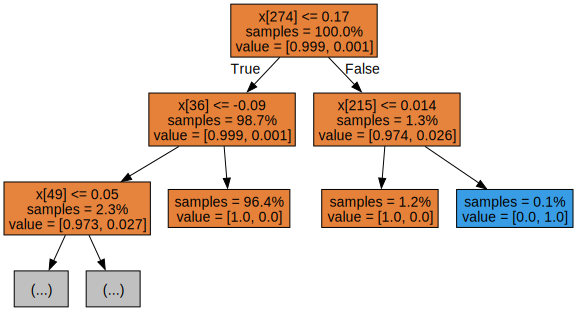

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


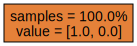

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


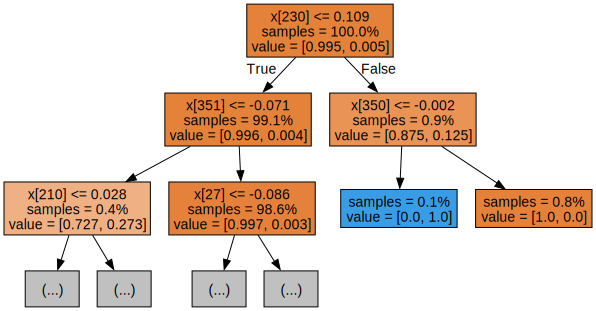

In [38]:
# Export the first three decision trees from the forest
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

for i in range(3):
    tree = clf.estimators_[i].estimators_[0]
    dot_data = export_graphviz(tree,
                            #    feature_names=mlb.classes_,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)
